In [50]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm, norm
import matplotlib.pyplot as plt
import seaborn as sns
from six import print_, moves


# Conditional Outcome Function
def conditional_outcome(s1, s2, result, sigma_t):
    mean_diff = s1 - s2
    std_diff = sigma_t

    if result == 1:
        a, b = 0, np.inf  
    else:
        a, b = -np.inf, 0  

    a_std = (a - mean_diff) / std_diff
    b_std = (b - mean_diff) / std_diff

    return a_std, b_std, mean_diff, std_diff

def gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    
    s1_current = mu_s1
    s2_current = mu_s2

    mu_prior = np.array([mu_s1, mu_s2]).reshape((2, 1))
    sigma_prior = np.array([[sigma_s1, 0], [0, sigma_s2]])
    sigma_prior_inv = np.linalg.inv(sigma_prior)

    A = np.array([1, -1]).reshape((1, 2))
    A_T = A.T

    for i in range(n_iter):
        a_std, b_std, mean_diff, std_diff = conditional_outcome(s1_current, s2_current, result, sigma_t)
        t_current = truncnorm.rvs(a=a_std, b=b_std, loc=mean_diff, scale=std_diff)
        sigma_post = np.linalg.inv(sigma_prior_inv + (A_T @ A) / sigma_t**2)
        mu_post = sigma_post @ (sigma_prior_inv @ mu_prior + (A_T * t_current) / sigma_t**2)
        s1_current, s2_current = np.random.multivariate_normal(mu_post.flatten(), sigma_post)
        s1_samples[i] = s1_current
        s2_samples[i] = s2_current
        t_samples[i] = t_current
        y_samples[i] = result

    mean_s1 = np.mean(s1_samples)
    var_s1 = np.var(s1_samples, ddof=1)
    mean_s2 = np.mean(s2_samples)
    var_s2 = np.var(s2_samples, ddof=1)

    return s1_samples, s2_samples, mean_s1, var_s1, mean_s2, var_s2

def win_probability_player1(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t):
    mu_diff = mu_s1 - mu_s2
    sigma_diff = np.sqrt(sigma_s1 + sigma_s2 + sigma_t**2)
    p_y1 = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)
    return p_y1


from scipy.stats import truncnorm


def multiplyGauss(m1, s1, m2, s2):
    s = 1 / (1 / s1 + 1 / s2)
    m = (m1 / s1 + m2 / s2) * s
    return m, s

def divideGauss(m1, s1, m2, s2):
    m,s =  multiplyGauss(m1, s1, m2, -s2)
    return m, s

def truncGaussMM(a,b,m0,s0):
    a_scaled, b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = truncnorm.mean(a_scaled,b_scaled, loc=m0, scale=np.sqrt(s0))
    s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    return m,s

Mean of s1: 29.3548547666797
Variance of s1: 49.26114970718884
Mean of s2: 20.60806579349994
Variance of s2: 47.62550469250761


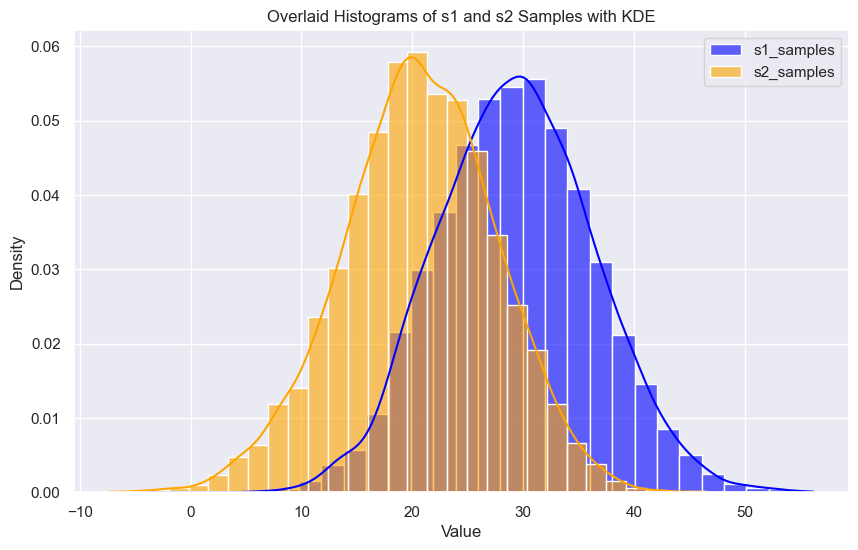

In [57]:
n = 8000 
mu1, sigma1 = 25, 8.33 ** 2
mu2, sigma2 = 25, 8.33 ** 2
sigma_t = (25 / 6) 
result = 1
s1_samples, s2_samples, s1_mean, s1_variance, s2_mean, s2_variance = gibbs_sampler_result(mu1, mu2, sigma1, sigma2, sigma_t, n, result)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the function gibbs_sampler_result is defined and working
# s1_samples, s2_samples, s1_mean, s1_variance, s2_mean, s2_variance = gibbs_sampler_result(mu1, mu2, sigma1, sigma2, sigma_t, n, result)

print(f"Mean of s1: {s1_mean}")
print(f"Variance of s1: {s1_variance}")
print(f"Mean of s2: {s2_mean}")
print(f"Variance of s2: {s2_variance}")

# Plot the overlaid histograms with fitted Gaussian curves (kernel density estimate)
plt.figure(figsize=(10, 6))

# Plot histogram and KDE for s1_samples
sns.histplot(s1_samples, bins=30, kde=True, color='blue', label='s1_samples', stat="density", alpha=0.6)

# Plot histogram and KDE for s2_samples
sns.histplot(s2_samples, bins=30, kde=True, color='orange', label='s2_samples', stat="density", alpha=0.6)

# Add a title and labels
plt.title("Overlaid Histograms of s1 and s2 Samples with KDE")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()




In [63]:
m1, s1 =  25, (25/3)**2
m2, s2 = 25, (25/3)**2
sv = (25/6)**2
y0 = 1
mu_diff_m = m1 - m2
mu_diff_s = s1 + s2 + sv


mu3_m = m1
mu3_s = s1

mu4_m = m2
mu4_s = s2


#print("Mu4_m: ", mu4_m, "Mu4_s: ", mu4_s, "Mu3_m: ", mu3_m, "Mu3_s: ", mu3_s)

mu5_m = mu_diff_m
mu5_s = mu_diff_s


if y0 == 1:
    a,b = 0, np.inf
else:
    a,b = -np.inf, 0


pt_m1, pt_s1 = truncGaussMM(a, b, mu5_m, mu5_s)
# Compute the message from t to f_3
mu6_m, mu6_s = divideGauss(pt_m1, pt_s1, mu5_m, mu5_s)
# Compute the message from f_3 to s1
mu7_m = mu6_m  + mu3_m
mu7_s = mu6_s + sv  + mu3_s
# Compute the message from f_3 to s2
px_m, px_s = multiplyGauss(mu3_m, mu3_s, mu7_m, mu7_s)
print(f"Mean of s1: {px_m}")
print(f"Variance of s1: {px_s}")



#compute the message from f_3 to s2
mu_8m = mu6_m - mu4_m
mu_8s = mu6_s + sv + mu4_s
px_m2, px_s2 = multiplyGauss(mu4_m, mu4_s, mu_8m, mu_8s)
print(f"Mean of s2: {px_m2}")
print(f"Variance of s2: {px_s2}")

Mean of s1: 29.43269200446036
Variance of s1: 49.79568603803762
Mean of s2: 15.285585951847445
Variance of s2: 49.79568603803762


Mean of s1 from moment matching: 29.43269200446036
Variance of s1 from moment matching: 49.79568603803762
Mean of s2 from moment matching: 29.43269200446036
Variance of s2 from moment matching: 49.79568603803762


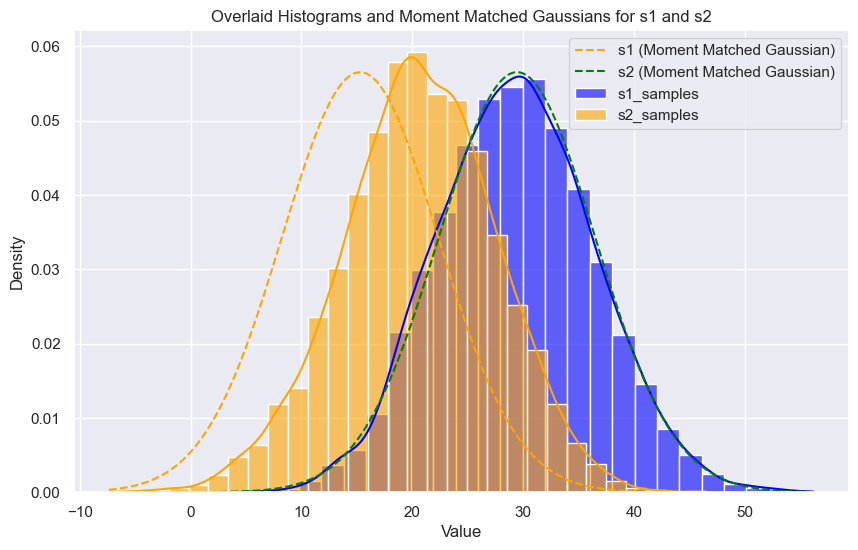

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# Assuming the functions multiplyGauss, divideGauss, truncGaussMM are defined and working

# Add your code for the moment matching process here to compute px_m and px_s
# Moment matching computations (as in the code you provided)
# (Insert your gibbs_sampler_result and other related code before this if necessary)

print(f"Mean of s1 from moment matching: {px_m}")
print(f"Variance of s1 from moment matching: {px_s}")
print(f"Mean of s2 from moment matching: {px_m}")
print(f"Variance of s2 from moment matching: {px_s}")

# Prepare to plot the histograms
plt.figure(figsize=(10, 6))

# Plot histogram and KDE for s1_samples
sns.histplot(s1_samples, bins=30, kde=True, color='blue', label='s1_samples', stat="density", alpha=0.6)

# Plot histogram and KDE for s2_samples
sns.histplot(s2_samples, bins=30, kde=True, color='orange', label='s2_samples', stat="density", alpha=0.6)

# Generate x-values for plotting the Gaussian distributions
x_values = np.linspace(min(np.min(s1_samples), np.min(s2_samples)), max(np.max(s1_samples), np.max(s2_samples)), 500)

# Plot the Gaussian for s1 from moment matching
plt.plot(x_values, norm.pdf(x_values, px_m2, np.sqrt(px_s)), color='orange', linestyle='--', label='s1 (Moment Matched Gaussian)')

# Plot the Gaussian for s2 from moment matching
plt.plot(x_values, norm.pdf(x_values, px_m, np.sqrt(px_s)), color='green', linestyle='--', label='s2 (Moment Matched Gaussian)')

# Add title, labels, and legend
plt.title("Overlaid Histograms and Moment Matched Gaussians for s1 and s2")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()
